## Pruning v/s Quantization in CNNs v/s ViT

Sakshi Mahadik

Jaiwin Shah

Surya Sukumar

### Import libraries + Load dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.quantization
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import timm
import copy
import os
import tempfile
from torch.ao.quantization import get_default_qconfig, prepare, convert
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver
from torch.ao.quantization.qconfig import QConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/jshah22/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/jshah22/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:00<00:00, 94.0MB/s]

Extracting files...


Path to dataset files: /home/jshah22/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [3]:
# Dataset loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = ImageFolder('fer2013/versions/1/train', transform=transform)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = ImageFolder('fer2013/versions/1/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check distribution
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 22968
Validation samples: 5741
Test samples: 7178


### Load Resnet18 model

In [4]:
from torchvision.models.quantization import mobilenet_v2

resnet18 = mobilenet_v2(pretrained=True, quantize=False)
resnet18.classifier[1] = nn.Linear(resnet18.last_channel, 7)
resnet18.eval()
resnet18.to(device)

/home/jshah22/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jshah22/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


QuantizableMobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): QuantizableInvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (2): QuantizableInvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): C

### Pruning and Quantization methods

In [5]:
# Unstructured Pruning for CNN
def unstructured_prune_cnn(model, amount=0.3):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")
    return model

# Structured Pruning for CNN
def structured_prune_cnn(model, amount=0.5):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
            prune.remove(module, "weight")
    return model

In [6]:
# Unstructured Pruning for ViT
def unstructured_prune_vit(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")
    return model

# Structured Attention Head Pruning for ViT
def prune_vit_attention_heads(model, heads_to_prune=2):
    for name, module in model.named_modules():
        if hasattr(module, 'qkv') and hasattr(module, 'num_heads'):
            heads_dim = module.qkv.weight.shape[0] // 3
            head_size = heads_dim // module.num_heads
            qkv_weights = module.qkv.weight.data.view(3, module.num_heads, head_size, -1)
            norms = qkv_weights.norm(dim=(2, 3))
            importance = norms.sum(dim=0)
            prune_indices = torch.topk(importance, heads_to_prune, largest=False).indices
            for i in prune_indices:
                qkv_weights[:, i, :, :] = 0
            module.qkv.weight.data = qkv_weights.view(-1, module.qkv.weight.shape[1])
    return model

In [7]:
def fuse_model_blocks(model):
    for module_name, module in model.named_children():
        if module_name == "features":
            for idx, m in enumerate(module):
                if isinstance(m, torch.nn.Sequential):
                    torch.quantization.fuse_modules(m, ["0", "1", "2"], inplace=True)
                elif hasattr(m, 'conv') and isinstance(m.conv, torch.nn.Sequential):
                    layers = []
                    for i, layer in enumerate(m.conv):
                        # Check pattern: Conv2d -> BatchNorm2d -> ReLU6 (optional)
                        if isinstance(layer, torch.nn.Conv2d):
                            if (i+1 < len(m.conv) and isinstance(m.conv[i+1], torch.nn.BatchNorm2d)):
                                if (i+2 < len(m.conv) and isinstance(m.conv[i+2], torch.nn.ReLU6)):
                                    layers.append([str(i), str(i+1), str(i+2)])
                                else:
                                    layers.append([str(i), str(i+1)])
                    for group in layers:
                        torch.quantization.fuse_modules(m.conv, group, inplace=True)

        elif module_name == "classifier":
            # No fusing needed here; it's typically [Dropout, Linear]
            continue

In [8]:
def quantize_trained_pruned_model(model, calibration_loader, num_batches=10):
    import copy
    model = copy.deepcopy(model)
    model.cpu().eval()

    # Fuse layers (must happen after pruning and training)
    fuse_model_blocks(model)

    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    torch.quantization.prepare(model, inplace=True)

    with torch.no_grad():
        for i, (x, _) in enumerate(calibration_loader):
            x = x.to(torch.float32)
            #x = x * 0.5 + 0.5  # Undo normalization: [0, 1]
            #x = torch.clamp(x, 0.0, 1.0)
            x.to("cpu")
            model(x)
            if i >= num_batches:
                break

    torch.quantization.convert(model, inplace=True)
    return model

In [9]:
def quantize_model(model, calibration_loader, num_batches=10):
    import copy
    model = copy.deepcopy(model)
    model.eval()
    model.cpu()

    # Fuse layers
    fuse_model_blocks(model)

    # Set quantization config and prepare
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    torch.quantization.prepare(model, inplace=True)

    # Calibration loop
    with torch.no_grad():
        for i, (x, _) in enumerate(calibration_loader):
            x = x.to(torch.float32)
            #x = x * 0.5 + 0.5  # Undo Normalize([0.5], [0.5])
            #x = torch.clamp(x, 0.0, 1.0)  # Ensure values in [0, 1]
            x.to("cpu")
            model(x)
            if i >= num_batches:
                break

    # Convert to quantized model
    torch.quantization.convert(model, inplace=True)
    return model

### Training and Evaluation methods

In [10]:
import time

def train(model, train_loader, val_loader, epochs=10, lr=1e-4):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                correct += (outputs.argmax(1) == y).sum().item()
                total += y.size(0)

        train_loss = running_loss / len(train_loader)
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

In [11]:
def evaluate(model, test_loader, quantization=False):
    model.eval()

    if quantization:
        model = model.to("cpu")  # Quantized models must be on CPU
    else:
        model = model.to("cuda")

    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            if quantization:
                x, y = x.to("cpu"), y.to("cpu")
            else:
                x, y = x.to("cuda"), y.to("cuda")

            outputs = model(x)
            pred = outputs.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy = {accuracy:.2f}%")
    return accuracy

In [12]:
def measure_inference_speed(model, test_loader, quantization=False):
    model.eval()
    
    if quantization:
        device = "cpu"
        
    else:
        device = torch.device("cuda")
    
    model.to(device)
    
    start = time.time()
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            _ = model(x)
    end = time.time()
    latency = (end - start) / len(test_loader)
    print(f"Avg Inference Time per Batch: {latency:.4f} sec")
    return latency

def model_size_mb(model, use_state_dict=True):
    with tempfile.NamedTemporaryFile(delete=False) as f:
        if use_state_dict:
            torch.save(model.state_dict(), f.name)
        else:
            torch.save(model, f.name)
        size_mb = os.path.getsize(f.name) / (1024 * 1024)
    print(f"Model Size ({'state_dict' if use_state_dict else 'full model'}): {size_mb:.2f} MB")
    return size_mb

### Plot methods

#### Accuracy v/s Pruning amount

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for polished look
sns.set(style="whitegrid", context="notebook")

def plot_validation_and_test_accuracy(pruning_amounts, val_accuracies, test_accuracies, pruning_type='structured'):
    """
    Plots validation and test accuracy vs. pruning amount for a specific pruning type.

    Args:
        pruning_amounts (list of float): Amounts of pruning applied (e.g., [0.0, 0.3, 0.5]).
        val_accuracies (list of float): Validation accuracies in percent.
        test_accuracies (list of float): Test accuracies in percent.
        pruning_type (str): 'structured' or 'unstructured' (used in plot title and legend).
    """
    plt.figure(figsize=(8, 5))

    plt.plot(pruning_amounts, val_accuracies, marker='o', label='Validation Accuracy', color='blue', linewidth=2)
    plt.plot(pruning_amounts, test_accuracies, marker='s', label='Test Accuracy', color='green', linewidth=2)

    # Annotate values
    for x, y in zip(pruning_amounts, val_accuracies):
        plt.text(x, y + 0.5, f"{y:.2f}%", ha='center', fontsize=9, color='blue')

    for x, y in zip(pruning_amounts, test_accuracies):
        plt.text(x, y - 1.5, f"{y:.2f}%", ha='center', fontsize=9, color='green')

    plt.xlabel("Pruning Amount", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title(f"{pruning_type.capitalize()} Pruning: Accuracy vs. Pruning Amount", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(pruning_amounts)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

def plot_accuracy_vs_pruning_grouped(pruning_type, pruning_amount, val_accuracies, test_accuracies):
    """
    Plots validation and test accuracy vs. pruning amount for multiple pruning types
    (e.g., 'baseline', 'structured', 'unstructured') on the same plot.

    Args:
        pruning_type (list of str): Type for each model ('baseline', 'structured', etc.)
        pruning_amount (list of float): Corresponding pruning amount (e.g., [0.0, 0.3, 0.5])
        val_accuracies (list of float): Corresponding validation accuracy in %
        test_accuracies (list of float): Corresponding test accuracy in %
    """
    plt.figure(figsize=(9, 5))

    unique_types = sorted(set(pruning_type))
    for ptype in unique_types:
        xs = [amt for t, amt in zip(pruning_type, pruning_amount) if t == ptype]
        #val_ys = [v for t, v in zip(pruning_type, val_accuracies) if t == ptype]
        test_ys = [v for t, v in zip(pruning_type, test_accuracies) if t == ptype]

        #plt.plot(xs, val_ys, marker='o', linestyle='-', linewidth=2, label=f'{ptype} - Val')
        plt.plot(xs, test_ys, marker='s', linestyle='-', linewidth=2, label=f'{ptype}')

        # Annotate points
        #for x, y in zip(xs, val_ys):
        #    plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)
        
        for x, y in zip(xs, test_ys):
            plt.text(x, y - 1.2, f"{y:.1f}%", ha='center', fontsize=9)

    plt.xlabel("Pruning Amount", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title("Accuracy vs. Pruning", fontsize=14)
    plt.legend(title="Model Type")
    plt.xticks(sorted(set(pruning_amount)))
    plt.ylim(50, 100)
    plt.tight_layout()
    plt.show()

#### Flops after pruning

In [15]:
from ptflops import get_model_complexity_info

# FLOPs calculation helper
def get_flops(model, input_res=(3, 224, 224)):
    model.eval()
    macs, params = get_model_complexity_info(model, input_res, as_strings=False,
                                              print_per_layer_stat=False, verbose=False)
    flops = 2 * macs  # Approximate FLOPs: 1 MAC = 2 FLOPs
    return flops / 1e9  # Convert to GFLOPs

In [16]:
# Count total and non-zero parameters (Conv + Linear)
def compute_sparsity(model):
    total_weights = 0
    nonzero_weights = 0

    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight'):
                total_weights += module.weight.nelement()
                nonzero_weights += torch.count_nonzero(module.weight)

    sparsity = 1 - (nonzero_weights / total_weights)
    return sparsity.item()

In [17]:
def plot_flops_after_pruning(labels, flops_values):
    plt.figure(figsize=(7, 4))
    bars = plt.bar(labels, flops_values, color=['steelblue', 'green', 'orange'])
    plt.title('Estimated Effective FLOPs After Pruning')
    plt.ylabel('FLOPs (GigaFLOPs)')
    plt.ylim(0, max(flops_values) * 1.2)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height * 1.01, f'{height:.2f}', ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Inference time accross pruning models

In [18]:
def plot_inference_vs_pruning(pruning_type, pruning_amount, inference_times):
    plt.figure(figsize=(8, 6))
    for ptype in set(pruning_type):
        xs = [amt for t, amt in zip(pruning_type, pruning_amount) if t == ptype]
        ys = [t for t_, t in zip(pruning_type, inference_times) if t_ == ptype]
        plt.plot(xs, ys, marker='o', label=ptype, linewidth=2)

        for x, y in zip(xs, ys):
            plt.text(x, y + 0.0005, f"{y:.4f}s", ha='center', fontsize=9)

    plt.xlabel("Pruning Amount", fontsize=12)
    plt.ylabel("Inference Time (s/batch)", fontsize=12)
    plt.title("Inference Time vs. Pruning", fontsize=14)
    plt.legend(title="Model Type")
    plt.xticks([0.0, 0.5])
    plt.tight_layout()
    plt.show()

#### Parameter Count across models

In [19]:
import matplotlib.pyplot as plt

def plot_parameter_counts(model_labels, param_counts_millions, title="Parameter Count Across Models"):
    """
    Plots parameter count (in millions) for different models.

    Args:
        model_labels (List[str]): Labels for each model (e.g., ['Baseline', 'Struct-0.3', 'Quantized', ...])
        param_counts_millions (List[float]): Corresponding parameter counts in millions
        title (str): Plot title
    """
    plt.figure(figsize=(10, 5))
    bars = plt.bar(model_labels, param_counts_millions, color='skyblue')

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.2f}M", ha='center', fontsize=10)

    plt.ylabel("Parameter Count (Millions)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=30, ha='right')
    plt.ylim(0, max(param_counts_millions) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [20]:
def get_parameter_count(model):
    """
    Returns non-zero parameter count (in millions) for any model,
    including quantized ones with packed weights.
    """
    nonzero = 0

    for module in model.modules():
        # Case 1: FP32 or pruned model
        if hasattr(module, "weight") and isinstance(module.weight, torch.Tensor):
            nonzero += torch.count_nonzero(module.weight).item()

        # Case 2: Quantized model (Conv2d, Linear, etc.)
        elif hasattr(module, "_packed_params") and hasattr(module._packed_params, "_weight_bias"):
            try:
                qweight, _ = module._packed_params._weight_bias()
                nonzero += torch.count_nonzero(qweight.dequantize()).item()
            except Exception:
                continue  # fallback silently

    return nonzero / 1e6  # millions


#### Accuracy v/s Preciison level

In [21]:
def plot_accuracy_vs_precision(precisions, accuracies):
    """
    Plot model accuracy vs. precision level.
    
    Args:
        precisions (List[str]): Precision levels (e.g., ['FP32', 'INT8'])
        accuracies (List[float]): Corresponding accuracies (%)
    """
    plt.figure(figsize=(15, 4))
    plt.plot(precisions, accuracies, marker='o', linewidth=2)
    plt.title("Accuracy vs. Precision Level")
    plt.xlabel("Precision")
    plt.ylabel("Accuracy (%)")
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.5, f"{acc:.2f}%", ha='center')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Inference time accross quantized models

In [22]:
import matplotlib.pyplot as plt

def plot_inference_time(models, times_ms):
    """
    Plot inference time for different models.
    
    Args:
        models (List[str]): Model labels (e.g., ['FP32', 'INT8', 'INT8+Pruned'])
        times_ms (List[float]): Inference times in milliseconds
    """
    plt.figure(figsize=(15, 4))
    plt.plot(models, times_ms, marker='o', linestyle='-', linewidth=2, color='red')
    plt.title("Inference Time Across Models")
    plt.xlabel("Model Type")
    plt.ylabel("Time (ms)")
    for i, t in enumerate(times_ms):
        plt.text(i, t + 0.1, f"{t:.1f} ms", ha='center')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Weight Distribution

In [23]:
import numpy as np

def extract_quantized_weights(model):
    """
    Extract quantized weights (int8) from a quantized model using _packed_params.
    Returns a list of flattened numpy arrays.
    """
    weights = []
    for module in model.modules():
        if isinstance(module, (torch.nn.quantized.Conv2d, torch.nn.quantized.Linear)):
            try:
                qweight, _ = module._packed_params._weight_bias()
                weights.append(qweight.dequantize().cpu().flatten().numpy())
            except Exception as e:
                #print(f"Skipping {module}: {e}")
                pass
    return np.concatenate(weights) if weights else None

def plot_quantized_weight_distribution(model_fp32, model_int8, model_int8_pr_st, model_int8_pr_unst):
    import matplotlib.pyplot as plt
    import numpy as np

    def extract_weights(model):
        weights = []
        for module in model.modules():
            if hasattr(module, "weight") and isinstance(module.weight, torch.Tensor):
                weights.append(module.weight.detach().cpu().flatten().numpy())
        return np.concatenate(weights) if weights else None

    w_fp32 = extract_weights(model_fp32)
    w_int8 = extract_quantized_weights(model_int8)
    w_int8_st = extract_quantized_weights(model_int8_pr_st)
    w_int8_unst = extract_quantized_weights(model_int8_pr_unst)

    if w_fp32 is None and w_int8 is None and w_int8_unst and w_int8_st:
        print("No weights found.")
        return

    plt.figure(figsize=(10, 4))
    if w_fp32 is not None:
        plt.subplot(1, 2, 1)
        plt.hist(w_fp32, bins=100, color='blue', alpha=0.7)
        plt.title("Weight Distribution (FP32)")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")

    if w_int8 is not None:
        plt.subplot(1, 2, 2)
        plt.hist(w_int8, bins=100, color='orange', alpha=0.7)
        plt.title("Weight Distribution (INT8)")
        plt.xlabel("Weight Value")
        
    plt.figure(figsize=(10, 6))
    if w_int8_st is not None:
        plt.subplot(2, 2, 1)
        plt.hist(w_int8_st, bins=100, color='green', alpha=0.7)
        plt.title("Weight Distribution (INT8 + Structured pruning)")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        
    if w_int8_unst is not None:
        plt.subplot(2, 2, 2)
        plt.hist(w_int8_unst, bins=100, color='red', alpha=0.7)
        plt.title("Weight Distribution (INT8 + Unstructured pruning)")
        plt.xlabel("Weight Value")

    plt.tight_layout()
    plt.show()

### Training

#### Training Baseline model

In [25]:
# === Train baseline ===
print("=== Train baseline ===")
train(resnet18, train_loader, val_loader, epochs=30)
evaluate(resnet18, test_loader)
model_size_mb(resnet18)
measure_inference_speed(resnet18, test_loader)
torch.save(resnet18, 'mobilenet_models/mobilenet.pt')

=== Train baseline ===
Epoch 1: Train Loss = 1.2474, Val Loss = 1.0419, Val Acc = 60.53%
Epoch 2: Train Loss = 0.9346, Val Loss = 0.9794, Val Acc = 63.96%
Epoch 3: Train Loss = 0.7408, Val Loss = 0.9928, Val Acc = 64.40%
Epoch 4: Train Loss = 0.5459, Val Loss = 1.0746, Val Acc = 63.63%
Epoch 5: Train Loss = 0.3507, Val Loss = 1.2456, Val Acc = 63.40%
Epoch 6: Train Loss = 0.2102, Val Loss = 1.3815, Val Acc = 63.73%
Epoch 7: Train Loss = 0.1289, Val Loss = 1.5792, Val Acc = 63.06%
Epoch 8: Train Loss = 0.0939, Val Loss = 1.6797, Val Acc = 62.85%
Epoch 9: Train Loss = 0.0895, Val Loss = 1.7198, Val Acc = 63.70%
Epoch 10: Train Loss = 0.0811, Val Loss = 1.8225, Val Acc = 62.78%
Epoch 11: Train Loss = 0.0713, Val Loss = 1.9364, Val Acc = 61.31%
Epoch 12: Train Loss = 0.0711, Val Loss = 1.9651, Val Acc = 62.60%
Epoch 13: Train Loss = 0.0759, Val Loss = 1.9793, Val Acc = 61.77%
Epoch 14: Train Loss = 0.0594, Val Loss = 2.0179, Val Acc = 61.47%
Epoch 15: Train Loss = 0.0584, Val Loss = 1.9965

In [25]:
resnet18=torch.load('mobilenet_models/mobilenet.pt', weights_only=False)

#### Pruning baseline model + Training (Structured)

In [26]:
# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_01 = structured_prune_cnn(resnet18, amount=0.1)
train(resnet18_pruned_st_01, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_01, test_loader)
model_size_mb(resnet18_pruned_st_01)
measure_inference_speed(resnet18_pruned_st_01, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_02 = structured_prune_cnn(resnet18, amount=0.2)
train(resnet18_pruned_st_02, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_02, test_loader)
model_size_mb(resnet18_pruned_st_02)
measure_inference_speed(resnet18_pruned_st_02, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_03 = structured_prune_cnn(resnet18, amount=0.3)
train(resnet18_pruned_st_03, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_03, test_loader)
model_size_mb(resnet18_pruned_st_03)
measure_inference_speed(resnet18_pruned_st_03, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_04 = structured_prune_cnn(resnet18, amount=0.4)
train(resnet18_pruned_st_04, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_04, test_loader)
model_size_mb(resnet18_pruned_st_04)
measure_inference_speed(resnet18_pruned_st_04, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_05 = structured_prune_cnn(resnet18, amount=0.5)
train(resnet18_pruned_st_05, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_05, test_loader)
model_size_mb(resnet18_pruned_st_05)
measure_inference_speed(resnet18_pruned_st_05, test_loader)

=== Apply structured pruning, then fine-tune ===
Epoch 1: Train Loss = 1.0883, Val Loss = 1.4513, Val Acc = 60.36%
Epoch 2: Train Loss = 0.4914, Val Loss = 1.4758, Val Acc = 61.80%
Epoch 3: Train Loss = 0.2934, Val Loss = 1.6111, Val Acc = 62.41%
Epoch 4: Train Loss = 0.1656, Val Loss = 1.7429, Val Acc = 62.79%
Epoch 5: Train Loss = 0.1108, Val Loss = 1.8295, Val Acc = 62.71%
Test Accuracy = 61.63%
Model Size (state_dict): 8.75 MB
Avg Inference Time per Batch: 0.1189 sec
=== Apply structured pruning, then fine-tune ===
Epoch 1: Train Loss = 1.4117, Val Loss = 1.1601, Val Acc = 56.96%
Epoch 2: Train Loss = 0.9857, Val Loss = 1.1090, Val Acc = 59.48%
Epoch 3: Train Loss = 0.8302, Val Loss = 1.0988, Val Acc = 61.03%
Epoch 4: Train Loss = 0.6930, Val Loss = 1.1437, Val Acc = 61.10%
Epoch 5: Train Loss = 0.5734, Val Loss = 1.2210, Val Acc = 60.43%
Test Accuracy = 60.31%
Model Size (state_dict): 8.75 MB
Avg Inference Time per Batch: 0.1116 sec
=== Apply structured pruning, then fine-tune ===

0.11652800678151899

In [27]:
torch.save(resnet18_pruned_st_01, 'mobilenet_models/mobilenet_pruned_st_01.pt')
torch.save(resnet18_pruned_st_02, 'mobilenet_models/mobilenet_pruned_st_02.pt')
torch.save(resnet18_pruned_st_03, 'mobilenet_models/mobilenet_pruned_st_03.pt')
torch.save(resnet18_pruned_st_04, 'mobilenet_models/mobilenet_pruned_st_04.pt')
torch.save(resnet18_pruned_st_05, 'mobilenet_models/mobilenet_pruned_st_05.pt')

In [26]:
resnet18_pruned_st_01=torch.load('mobilenet_models/mobilenet_pruned_st_01.pt', weights_only=False)
resnet18_pruned_st_02=torch.load('mobilenet_models/mobilenet_pruned_st_02.pt', weights_only=False)
resnet18_pruned_st_03=torch.load('mobilenet_models/mobilenet_pruned_st_03.pt', weights_only=False)
resnet18_pruned_st_04=torch.load('mobilenet_models/mobilenet_pruned_st_04.pt', weights_only=False)
resnet18_pruned_st_05=torch.load('mobilenet_models/mobilenet_pruned_st_05.pt', weights_only=False)

In [27]:
val_accuracies_st = []
"""val_acc = evaluate(resnet18_pruned_st_01, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_02, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_03, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_04, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_05, val_loader, quantization=False)
val_accuracies_st.append(val_acc)"""

test_accuracies_st = []
test_acc = evaluate(resnet18_pruned_st_01, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(resnet18_pruned_st_02, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(resnet18_pruned_st_03, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(resnet18_pruned_st_04, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(resnet18_pruned_st_05, test_loader, quantization=False)
test_accuracies_st.append(test_acc)

Test Accuracy = 61.63%
Test Accuracy = 60.31%
Test Accuracy = 59.26%
Test Accuracy = 59.97%
Test Accuracy = 59.33%


In [28]:
inf_speed = []
inf_speed_01 = measure_inference_speed(resnet18_pruned_st_01, test_loader, quantization=False)
inf_speed.append(inf_speed_01)
inf_speed_02 = measure_inference_speed(resnet18_pruned_st_02, test_loader, quantization=False)
inf_speed.append(inf_speed_02)
inf_speed_03 = measure_inference_speed(resnet18_pruned_st_03, test_loader, quantization=False)
inf_speed.append(inf_speed_03)
inf_speed_04 = measure_inference_speed(resnet18_pruned_st_04, test_loader, quantization=False)
inf_speed.append(inf_speed_04)
inf_speed_05 = measure_inference_speed(resnet18_pruned_st_05, test_loader, quantization=False)
inf_speed.append(inf_speed_05)

Avg Inference Time per Batch: 0.1317 sec
Avg Inference Time per Batch: 0.1444 sec
Avg Inference Time per Batch: 0.1414 sec
Avg Inference Time per Batch: 0.1342 sec
Avg Inference Time per Batch: 0.1105 sec


#### Pruning baseline model + Training (Unstructured)

In [30]:
# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_01 = unstructured_prune_cnn(resnet18, amount=0.1)
train(resnet18_pruned_unst_01, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_01, test_loader)
model_size_mb(resnet18_pruned_unst_01)
measure_inference_speed(resnet18_pruned_unst_01, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_02 = unstructured_prune_cnn(resnet18, amount=0.2)
train(resnet18_pruned_unst_02, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_02, test_loader)
model_size_mb(resnet18_pruned_unst_02)
measure_inference_speed(resnet18_pruned_unst_02, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_03 = unstructured_prune_cnn(resnet18, amount=0.3)
train(resnet18_pruned_unst_03, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_03, test_loader)
model_size_mb(resnet18_pruned_unst_03)
measure_inference_speed(resnet18_pruned_unst_03, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_04 = unstructured_prune_cnn(resnet18, amount=0.4)
train(resnet18_pruned_unst_04, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_04, test_loader)
model_size_mb(resnet18_pruned_unst_04)
measure_inference_speed(resnet18_pruned_unst_04, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_05 = unstructured_prune_cnn(resnet18, amount=0.5)
train(resnet18_pruned_unst_05, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_05, test_loader)
model_size_mb(resnet18_pruned_unst_05)
measure_inference_speed(resnet18_pruned_unst_05, test_loader)

=== Apply unstructured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.0238, Val Loss = 2.1961, Val Acc = 64.41%
Epoch 2: Train Loss = 0.0094, Val Loss = 2.2089, Val Acc = 64.50%
Epoch 3: Train Loss = 0.0076, Val Loss = 2.2076, Val Acc = 64.47%
Epoch 4: Train Loss = 0.0058, Val Loss = 2.2264, Val Acc = 64.38%
Epoch 5: Train Loss = 0.0052, Val Loss = 2.2359, Val Acc = 64.81%
Test Accuracy = 63.72%
Model Size (state_dict): 8.75 MB
Avg Inference Time per Batch: 0.1154 sec
=== Apply unstructured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.0620, Val Loss = 2.2425, Val Acc = 63.70%
Epoch 2: Train Loss = 0.0221, Val Loss = 2.2505, Val Acc = 63.75%
Epoch 3: Train Loss = 0.0133, Val Loss = 2.2291, Val Acc = 63.98%
Epoch 4: Train Loss = 0.0095, Val Loss = 2.2692, Val Acc = 64.00%
Epoch 5: Train Loss = 0.0081, Val Loss = 2.2738, Val Acc = 63.89%
Test Accuracy = 64.06%
Model Size (state_dict): 8.75 MB
Avg Inference Time per Batch: 0.1211 sec
=== Apply unstructured pruning, then fine-tu

0.11590636093004615

In [31]:
torch.save(resnet18_pruned_unst_01, 'mobilenet_models/mobilenet_pruned_unst_01.pt')
torch.save(resnet18_pruned_unst_02, 'mobilenet_models/mobilenet_pruned_unst_02.pt')
torch.save(resnet18_pruned_unst_03, 'mobilenet_models/mobilenet_pruned_unst_03.pt')
torch.save(resnet18_pruned_unst_04, 'mobilenet_models/mobilenet_pruned_unst_04.pt')
torch.save(resnet18_pruned_unst_05, 'mobilenet_models/mobilenet_pruned_unst_05.pt')

In [29]:
resnet18_pruned_unst_01=torch.load('mobilenet_models/mobilenet_pruned_unst_01.pt', weights_only=False)
resnet18_pruned_unst_02=torch.load('mobilenet_models/mobilenet_pruned_unst_02.pt', weights_only=False)
resnet18_pruned_unst_03=torch.load('mobilenet_models/mobilenet_pruned_unst_03.pt', weights_only=False)
resnet18_pruned_unst_04=torch.load('mobilenet_models/mobilenet_pruned_unst_04.pt', weights_only=False)
resnet18_pruned_unst_05=torch.load('mobilenet_models/mobilenet_pruned_unst_05.pt', weights_only=False)

In [30]:
val_accuracies_unst = []
"""val_acc = evaluate(resnet18_pruned_unst_01, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_02, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_03, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_04, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_05, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)"""

test_accuracies_unst = []
test_acc = evaluate(resnet18_pruned_unst_01, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(resnet18_pruned_unst_02, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(resnet18_pruned_unst_03, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(resnet18_pruned_unst_04, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(resnet18_pruned_unst_05, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)

Test Accuracy = 63.72%
Test Accuracy = 64.06%
Test Accuracy = 62.82%
Test Accuracy = 61.12%
Test Accuracy = 58.14%


In [31]:
baseline_accuracy = evaluate(resnet18, test_loader)
baseline_inf_speed = measure_inference_speed(resnet18, test_loader)

Test Accuracy = 62.55%
Avg Inference Time per Batch: 0.1153 sec


In [34]:
resnet18_pruned_st_01 = torch.load('mobilenet_models/mobilenet_pruned_st_01.pt', weights_only=False)
resnet18_pruned_st_02 = torch.load('mobilenet_models/mobilenet_pruned_st_02.pt', weights_only=False)
resnet18_pruned_st_03 = torch.load('mobilenet_models/mobilenet_pruned_st_03.pt', weights_only=False)
resnet18_pruned_st_04 = torch.load('mobilenet_models/mobilenet_pruned_st_04.pt', weights_only=False)
resnet18_pruned_unst_01 = torch.load('mobilenet_models/mobilenet_pruned_unst_01.pt', weights_only=False)
resnet18_pruned_unst_02 = torch.load('mobilenet_models/mobilenet_pruned_unst_02.pt', weights_only=False)
resnet18_pruned_unst_03 = torch.load('mobilenet_models/mobilenet_pruned_unst_03.pt', weights_only=False)
resnet18_pruned_unst_04 = torch.load('mobilenet_models/mobilenet_pruned_unst_04.pt', weights_only=False)

#### Plots related to Pruning

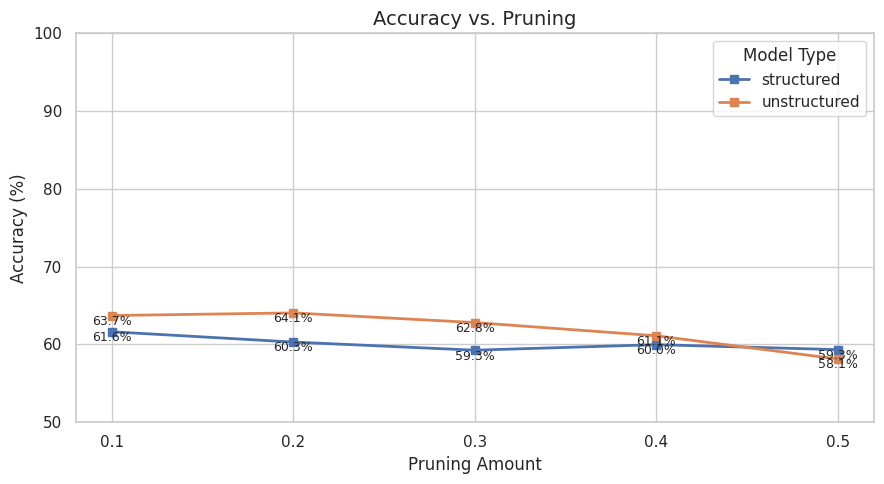

Baseline Accuracy: 62.5522429646141


In [32]:
pruning_amounts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]
pruning_type = ['structured', 'structured', 'structured', 'structured', 'structured', 'unstructured', 'unstructured', 'unstructured', 'unstructured', 'unstructured']
plot_accuracy_vs_pruning_grouped(pruning_type, pruning_amounts, val_accuracies_st + val_accuracies_unst, test_accuracies_st + test_accuracies_unst)
print(f"Baseline Accuracy: {baseline_accuracy}")

In [33]:
inf_speed_un = []
inf_speed_01 = measure_inference_speed(resnet18_pruned_unst_01, test_loader, quantization=False)
inf_speed_un.append(inf_speed_01)
inf_speed_02 = measure_inference_speed(resnet18_pruned_unst_02, test_loader, quantization=False)
inf_speed_un.append(inf_speed_02)
inf_speed_03 = measure_inference_speed(resnet18_pruned_unst_03, test_loader, quantization=False)
inf_speed_un.append(inf_speed_03)
inf_speed_04 = measure_inference_speed(resnet18_pruned_unst_04, test_loader, quantization=False)
inf_speed_un.append(inf_speed_04)
inf_speed_05 = measure_inference_speed(resnet18_pruned_unst_05, test_loader, quantization=False)
inf_speed_un.append(inf_speed_05)

Avg Inference Time per Batch: 0.1162 sec
Avg Inference Time per Batch: 0.1169 sec
Avg Inference Time per Batch: 0.1145 sec
Avg Inference Time per Batch: 0.1139 sec
Avg Inference Time per Batch: 0.1147 sec


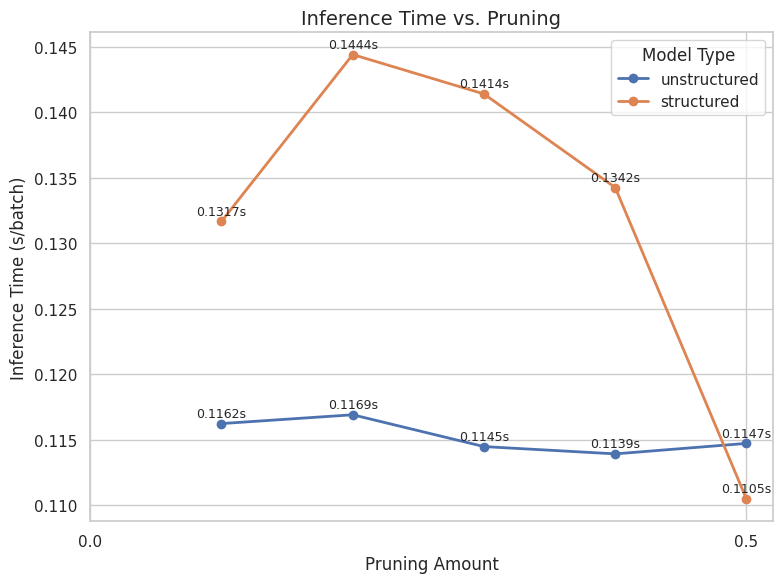

In [34]:
pruning_type = ['structured', 'structured', 'structured', 'structured', 'structured', 'unstructured', 'unstructured', 'unstructured', 'unstructured', 'unstructured']
plot_inference_vs_pruning(pruning_type, pruning_amounts, inf_speed + inf_speed_un)

In [35]:
# Get FLOPs before pruning
flops_before = get_flops(resnet18)

structured_sparsity = compute_sparsity(resnet18_pruned_st_05)
flops_structured_effective = flops_before * (1 - structured_sparsity)

unstructured_sparsity = compute_sparsity(resnet18_pruned_unst_05)
flops_unstructured_effective = flops_before * (1 - unstructured_sparsity)

print(f"FLOPs before pruning: {flops_before:.2f} GFLOPs")
print(f"Structured Pruning: sparsity = {structured_sparsity:.2%}, effective FLOPs = {flops_structured_effective:.2f} GFLOPs")
print(f"Unstructured Pruning: sparsity = {unstructured_sparsity:.2%}, effective FLOPs = {flops_unstructured_effective:.2f} GFLOPs")

FLOPs before pruning: 0.65 GFLOPs
Structured Pruning: sparsity = 21.45%, effective FLOPs = 0.51 GFLOPs
Unstructured Pruning: sparsity = 0.30%, effective FLOPs = 0.65 GFLOPs


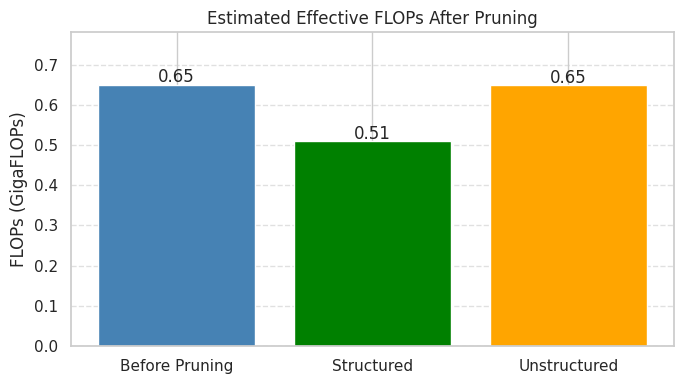

In [36]:
labels = ['Before Pruning', 'Structured', 'Unstructured']
flops_values = [flops_before, flops_structured_effective, flops_unstructured_effective]

plot_flops_after_pruning(labels, flops_values)

#### Quantization

In [44]:
resnet18 = torch.load('mobilenet_models/mobilenet.pt', weights_only=False)
resnet18_pruned_unst_05 = torch.load('mobilenet_models/mobilenet_pruned_unst_05.pt', weights_only=False)
resnet18_pruned_st_05 = torch.load('mobilenet_models/mobilenet_pruned_st_05.pt', weights_only=False)

In [39]:
resnet18_quant = quantize_model(resnet18, train_loader)
resnet18_quant_pr_st = quantize_trained_pruned_model(resnet18_pruned_st_05, train_loader)
resnet18_quant_pr_unst = quantize_trained_pruned_model(resnet18_pruned_unst_05, train_loader)

/home/jshah22/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/jshah22/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:1318: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [45]:
# === Apply quantization on baseline (no pruning) ===
print("=== Apply quantization on baseline (no pruning) ===")
resnet18_quant = quantize_model(resnet18, train_loader)
evaluate(resnet18_quant, test_loader, quantization=True)
model_size_mb(resnet18_quant)
measure_inference_speed(resnet18_quant, test_loader, quantization=True)

# === Apply quantization on pruned model ===
print("=== Apply quantization on pruned model ===")
resnet18_quant_pr_st = quantize_trained_pruned_model(resnet18_pruned_st_05, train_loader)
evaluate(resnet18_quant_pr_st, test_loader, quantization=True)
model_size_mb(resnet18_quant_pr_st)
measure_inference_speed(resnet18_quant_pr_st, test_loader, quantization=True)

print("=== Apply quantization on pruned model ===")
resnet18_quant_pr_unst = quantize_trained_pruned_model(resnet18_pruned_unst_05, train_loader)
evaluate(resnet18_quant_pr_unst, test_loader, quantization=True)
model_size_mb(resnet18_quant_pr_unst)
measure_inference_speed(resnet18_quant_pr_unst, test_loader, quantization=True)

=== Apply quantization on baseline (no pruning) ===


/home/jshah22/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/jshah22/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:1318: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


Test Accuracy = 36.25%
Model Size (state_dict): 2.75 MB
Avg Inference Time per Batch: 0.2269 sec
=== Apply quantization on pruned model ===
Test Accuracy = 7.45%
Model Size (state_dict): 2.75 MB
Avg Inference Time per Batch: 0.2261 sec
=== Apply quantization on pruned model ===
Test Accuracy = 22.44%
Model Size (state_dict): 2.75 MB
Avg Inference Time per Batch: 0.2320 sec


0.23196907170050968

In [46]:
torch.save(resnet18_quant, 'mobilenet_models/mobilenet_quant.pt')
torch.save(resnet18_quant_pr_st, 'mobilenet_models/mobilenet_quant_pr_st.pt')
torch.save(resnet18_quant_pr_unst, 'mobilenet_models/mobilenet_quant_pr_unst.pt')

In [37]:
resnet18_quant = torch.load('mobilenet_models/mobilenet_quant.pt', weights_only=False)
resnet18_quant_pr_st = torch.load('mobilenet_models/mobilenet_quant_pr_st.pt', weights_only=False)
resnet18_quant_pr_unst = torch.load('mobilenet_models/mobilenet_quant_pr_unst.pt', weights_only=False)

/home/jshah22/.local/lib/python3.10/site-packages/torch/_utils.py:431: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [40]:
accuracies = []
accuracy_baseline = evaluate(resnet18, test_loader, quantization=True)
accuracy_quant = evaluate(resnet18_quant, test_loader, quantization=True)
accuracy_quant_pr_st = evaluate(resnet18_quant_pr_st, test_loader, quantization=True)
accuracy_quant_pr_unst = evaluate(resnet18_quant_pr_unst, test_loader, quantization=True)
accuracies.append(accuracy_baseline)
accuracies.append(accuracy_quant)
accuracies.append(accuracy_quant_pr_st)
accuracies.append(accuracy_quant_pr_unst)

Test Accuracy = 62.55%
Test Accuracy = 38.06%
Test Accuracy = 13.35%
Test Accuracy = 21.72%


In [41]:
inf_speeds_quantization = []
inf_speed_baseline = measure_inference_speed(resnet18, test_loader, quantization=True)
inf_speed_quant = measure_inference_speed(resnet18_quant, test_loader, quantization=True)
inf_speed_quant_pr_st = measure_inference_speed(resnet18_quant_pr_st, test_loader, quantization=True)
inf_speed_quant_pr_unst = measure_inference_speed(resnet18_quant_pr_unst, test_loader, quantization=True)
inf_speeds_quantization.append(inf_speed_baseline)
inf_speeds_quantization.append(inf_speed_quant)
inf_speeds_quantization.append(inf_speed_quant_pr_st)
inf_speeds_quantization.append(inf_speed_quant_pr_unst)

Avg Inference Time per Batch: 1.0021 sec
Avg Inference Time per Batch: 0.2363 sec
Avg Inference Time per Batch: 0.2340 sec
Avg Inference Time per Batch: 0.2339 sec


#### Plots related to Quantization

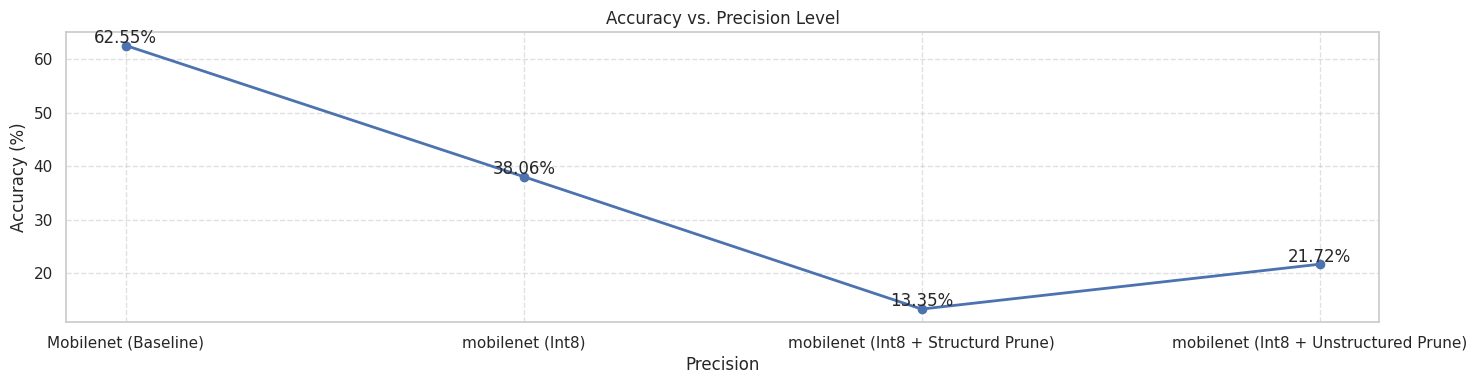

In [42]:
precisions = ['Mobilenet (Baseline)', 'mobilenet (Int8)', 'mobilenet (Int8 + Structurd Prune)', 'mobilenet (Int8 + Unstructured Prune)']
plot_accuracy_vs_precision(precisions, accuracies)

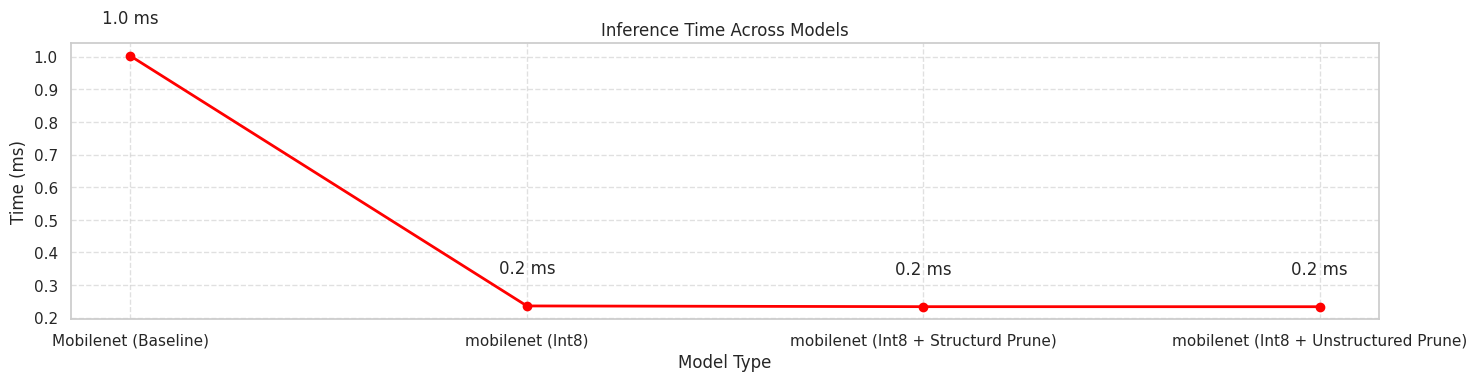

In [43]:
plot_inference_time(precisions, inf_speeds_quantization)

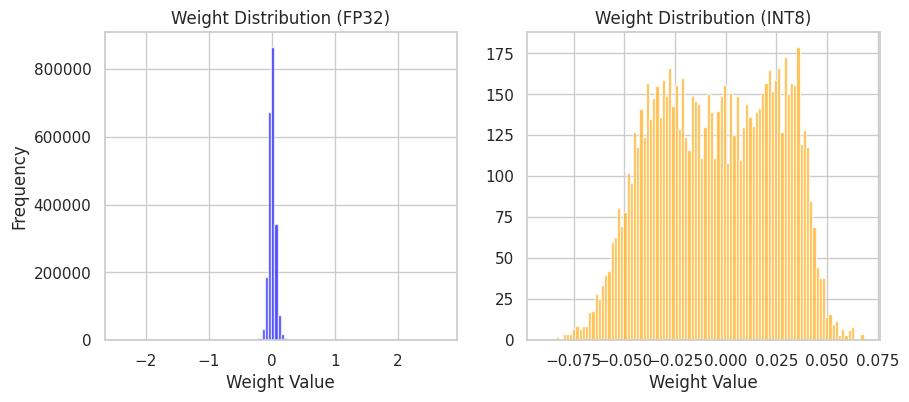

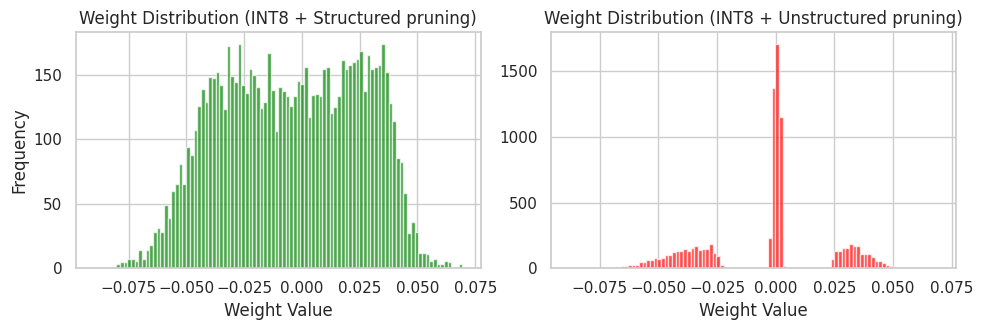

In [44]:
plot_quantized_weight_distribution(resnet18, resnet18_quant, resnet18_quant_pr_st, resnet18_quant_pr_unst)

#### Parameter Count plot

In [45]:
model_labels = []
param_counts = []

# FP32 Baseline
model_labels.append("Baseline")
param_counts.append(get_parameter_count(resnet18))

# Pruned (structured & unstructured)
model_labels += ["Structured-0.5", "Unstructured-0.5"]
param_counts += [
    get_parameter_count(resnet18_pruned_st_05),
    get_parameter_count(resnet18_pruned_unst_05),
]


In [46]:
print("=== Parameter Count ===")
for i, j in zip(model_labels, param_counts):
    print(f"{i}: {j}")

=== Parameter Count ===
Baseline: 2.215776
Structured-0.5: 1.744252
Unstructured-0.5: 2.20924
